In [55]:
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MaxNLocator
from matplotlib.offsetbox import AnchoredText
from brainpipe.visual import *
from scipy.stats import sem
import seaborn as sns

In [ ]:
def plot_jitter_behav(df,subjects,df_stats,stat_meth,
                            factor,plot_name,data_ind=False):
    conds = df.columns
    if factor.split('_')[-1] in ['volume','max']:
        df = abs(df)
    means = df.mean().values 
    err = df.sem().values 
    id_subj = [i for i,_ in enumerate(subjects)]
    print(means,err)
    
    #Convert df in order to plot Violin distribution
    df2 = df_stat.stack()
    df3 = df2.reset_index(inplace=False,drop=False,name=factor)
    df3.rename(columns={'level_0':'subjects', 'level_1':'conds'},inplace=True)
    print(df3)
    
    #Plot BAR PLOTS // data from all subjects
    ind = np.arange(len(conds))  # the x locations for the groups
    width = 0.8      # the width of the bars
    fig, ax = plt.subplots(figsize=(3,4))
    
    ax = sns.violinplot(x='score_episodic_strict',y=factor,data=df3,color='grey',linewidth=0.5,
                        bw=0.5,scale='width')
    ax = sns.pointplot(x="score_episodic_strict", y=factor, data=df3,ci=None,color='black',linewidth=0.5)
    #ax.bar(ind, means, width, color='grey', yerr=err,zorder=-1)
    #ax.errorbar(ind, means, yerr=err, fmt='o', color='black',
    #         ecolor='lightgray', elinewidth=3, capsize=0)
    #ax.plot(ind, means)
    #ax.set_ylabel(factor+' by memory richness', fontsize=14)
    #ax.set_xticks(ind)
    #ax.set_xticklabels(conds,fontsize=11)

    # Add all values for each patient
    if data_ind == True:
        x0 = np.random.normal(ind[0], 0.1, size=df.shape[0]) #to not have all values on the same x
        x1 = np.random.normal(ind[1], 0.1, size=df.shape[0])
        x2 = np.random.normal(ind[2], 0.1, size=df.shape[0])

        colormap = np.array(["darkblue", "deepskyblue", "mediumspringgreen",
                             "yellow", "darkorange","red"])
        ax.scatter(x0,df[[conds[0]]].values, marker='o',alpha=1.,
                                           c=colormap[id_subj],zorder=1,s=50)
        ax.scatter(x1,df[[conds[1]]].values,marker='o',alpha=1.,
                                           c=colormap[id_subj],zorder=1,s=50)
        ax.scatter(x2,df[[conds[2]]].values,marker='o',alpha=1.,
                                           c=colormap[id_subj],zorder=1,s=50)
        rmaxis(plt.gca(), ['right', 'top'])
        ax.legend(loc=0, handletextpad=0.1, frameon=False)
        ax.yaxis.set_major_locator(MaxNLocator(4,integer=True))
    
    #plot the stats
    if stat_meth == 'ANOVA':
        anchored_text = AnchoredText('t = %s \np = %s' \
             % (np.round(stats['F'].values[0],2), np.round(stats['p-unc'].values[0],2)),loc=2)
    elif stat_meth == 'LinearReg':
        anchored_text = AnchoredText('t = %s \np = %s' \
             % (stats[0], stats[1]),loc=2)
    ax.add_artist(anchored_text)
    plt.tight_layout()
    fignames = [plot_name, plot_name.replace('.png','.pdf')]
    for name in fignames:
        plt.savefig(name, dpi=600)

#### ANOVA for Memory Richness effect on breathing and ITI/Count at E
- Global effect of Memory Richness
- Plot data averaged and singl-subject with colors and stats

In [ ]:
from utils import odor_groups_3wgth
import pingouin as pg

PATH = '/media/karim/Datas4To/1_Analyses_Intra_EM_Odor/1bis_OE_BaseSam/JPlailly201306_seeg_ALS/behavior/'
df_name = path.join(PATH,'Repiration features individual total {}.xls')
path_save = path.join(PATH, 'plots/Plot_{}_{}_stat.png')
exps = ['R']
conds = ['low','mid','high']
sel_cols = ['delta_time_next_trial','total_encodage_mean_exp_duration',
           'total_encodage_mean_exp_volume', 'total_encodage_mean_exp_max',
           'total_encodage_mean_insp_duration','total_encodage_mean_insp_volume',
           'total_encodage_mean_insp_max','trial_index']

for exp in exps:
    if exp == 'R':
        sel_cols = [x.replace('encodage_','') for x in sel_cols[1:-1]]
    for col in sel_cols:
        data = np.zeros((len([x for x in odor_groups_3wgth]),len(conds)))
        subjects = [su for su in odor_groups_3wgth]
        for s,su in enumerate(odor_groups_3wgth):
            df = pd.read_excel(df_name.format(exp), sheet_name=su)
            df_sel = df[['odor_num',col]]
            for c,cond in enumerate(conds):
                od_data = []
                for od in odor_groups_3wgth[su][cond]:
                    val = df_sel.loc[df_sel['odor_num']==int(od)][col].values[0]
                    od_data.append(np.round(val,3))                    
                data[s,c] += np.mean(od_data)
        df_stat = pd.DataFrame(data,columns=conds)
        stats = pg.rm_anova(df_stat)
        print(exp,col)
        print(stats,'\n')
        col_name = col.split('_')[-2]+'_'+col.split('_')[-1]
        print(col_name)
        plot_jitter_behav(df_stat,subjects,stats,col_name,path_save.format(exp,col_name))
        del df_stat, stats, data

#### Linear Regression for Memory Richness effect on breathing and ITI/Count at E
- Regression effect of Memory Richness (one analysis with AVERAGED data by SUBJ)
- Plot data averaged and singl-subject with colors and stats

In [ ]:
from utils import odor_groups_3wgth
import statsmodels.api as sm

PATH = '/media/karim/Datas4To/1_Analyses_Intra_EM_Odor/1bis_OE_BaseSam/JPlailly201306_seeg_ALS/behavior/'
df_name = path.join(PATH,'Repiration features individual total {}.xls')
path_save = path.join(PATH, 'plots/Plot_{}_{}_{}_stat.png')
exps = ['E','R']
stat_meth = 'LinearReg'
conds = ['low','mid','high']
dict_perf = {'low':1, 'mid':2, 'high':3}

sel_cols = ['delta_time_next_trial','total_encodage_mean_exp_duration',
           'total_encodage_mean_exp_volume', 'total_encodage_mean_exp_max',
           'total_encodage_mean_insp_duration','total_encodage_mean_insp_volume',
           'total_encodage_mean_insp_max','trial_index']

for exp in exps:
    if exp == 'R':
        sel_cols = [x.replace('encodage_','') for x in sel_cols[1:-1]]
    for col in sel_cols:
        data_stat = np.zeros((len([x for x in odor_groups_3wgth]),len(conds)))
        data, score = [], []
        for s,su in enumerate(odor_groups_3wgth):
            df = pd.read_excel(df_name.format(exp), sheet_name=su)
            df_sel = df[['odor_num',col]]
            for c,cond in enumerate(conds):
                od_data = []
                for od in odor_groups_3wgth[su][cond]:
                    val = df_sel.loc[df_sel['odor_num']==int(od)][col].values[0]
                    od_data.append(np.round(val,3))    
                data_stat[s,c] += np.mean(od_data)
                data.append(np.mean(od_data))
                score.append(dict_perf[cond])
        df_stat = pd.DataFrame(data_stat,columns=conds)
        Y, X = np.array(data), sm.add_constant(score)
        model_ols = sm.OLS(Y,X).fit()
        stats = np.round(model_ols.tvalues[1],3),np.round(model_ols.pvalues[1],3)
        print('\n',exp,col.upper())
        print(model_ols.summary())
        #print(stats,'\n')
        col_name = col.split('_')[-2]+'_'+col.split('_')[-1]
        #plot_jitter_behav(df_stat,subjects,stats,stat_meth,
                                  #col_name,path_save.format(exp,stat_meth,col_name))
        del stats, data

## Stats for Memory richness perf
- different df (no breathing recordings there)

In [ ]:
from os import path
import numpy as np
import pandas as pd
from utils import odor_groups_3wgth
import statsmodels.api as sm

PATH = '/media/karim/Datas4To/1_Analyses_Intra_EM_Odor/1bis_OE_BaseSam/JPlailly201306_seeg_ALS/behavior/'
df_name = path.join(PATH,'episodic_all_su_all_trials_old_odors.csv')
path_save = path.join(PATH, 'plots/Plot_{}_{}_{}_stat.png')
stat_meth, exp = 'LinearReg', 'R'
subjects = [su for su in odor_groups_3wgth]
conds = ['low','mid','high']
#features = ['epi_chance_wght','odor_recognition_rt','episodic_rt']
features = ['epi_chance_wght','epi_RT_wght']
dict_perf = {'low':1, 'mid':2, 'high':3}


df = pd.read_csv(df_name)
print(df.columns)

for feat in features:
    data_stat = np.zeros((len([x for x in odor_groups_3wgth]),len(conds)))
    data, score = [], []
    for s,su in enumerate(odor_groups_3wgth):
        df_sel = df.loc[df['subject_name']==su]
        df_sel = df_sel[['odor_num',feat]]
        df_sel_gr = df_sel.groupby('odor_num').mean()
        print(su,df_sel_gr)
        for c,cond in enumerate(conds):
            od_data = []
            for od in odor_groups_3wgth[su][cond]:
                idx = [i for i,j in enumerate(df_sel_gr.index) if j==int(od)]
                val = df_sel_gr.iloc[idx,0].values[0]
                print(su,od,val,idx)
                od_data.append(np.round(val,3))    
            data_stat[s,c] += np.mean(od_data)
            data.append(np.mean(od_data))
            score.append(dict_perf[cond])
    df_stat = pd.DataFrame(data_stat,columns=conds)
    Y, X = np.array(data), sm.add_constant(score)
    model_ols = sm.OLS(Y,X).fit()
    stats = np.round(model_ols.tvalues[1],3),np.round(model_ols.pvalues[1],3)
    print(feat)
    print(model_ols.summary(),'\n')
    #plot_jitter_behav(df_stat,subjects,stats,stat_meth,
    #                          feat,path_save.format(exp,stat_meth,feat))
    del stats, data

--> processing stats
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     17.12
Date:                Fri, 03 Jul 2020   Prob (F-statistic):           0.000510
Time:                        11:38:10   Log-Likelihood:                 36.218
No. Observations:                  22   AIC:                            -68.44
Df Residuals:                      20   BIC:                            -66.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3278      0.01

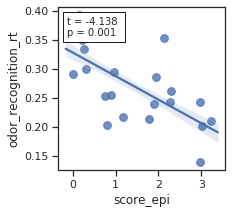

In [91]:
"""Plot RT and perf counts barplots and Stats"""
from os import path
import numpy as np
import pandas as pd
from utils import odor_groups_3wgth
import statsmodels.api as sm
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

PATH = '/media/karim/Datas4To/1_Analyses_Intra_EM_Odor/1bis_OE_BaseSam/JPlailly201306_seeg_ALS/behavior/'
df_name = path.join(PATH,'episodic_all_su_all_trials_old_odors.csv')
path_save = path.join(PATH, 'plots/Plot_bars_{}_stat.png')
path_save2 = path.join(PATH, 'plots/LinReg_{}_stat.png')
dict_conds = {'WWhere-S1':'WWhich-S1','WWhich-S1':'WWhich-S1','WWW-S1':'WWW-S1',
             'What-S1':'What-S1','miss':'miss'}
dict_score = {'WWhich-S1':2,'WWW-S1':3,'What-S1':1,'miss':0}
feat = 'odor_recognition_rt'

df = pd.read_csv(df_name)
df = df.drop(labels='Unnamed: 0', axis=1)
df['episodic_rt_delta'] = df['episodic_rt'] - df['odor_recognition_rt']
#df = df.loc[df['score_episodic_strict'] != 'miss']

df['score_episodic_strict'] = df['score_episodic_strict'].map(dict_conds) #remove WWhere and put in WWhich sections
#df = df.loc[(df['score_episodic_strict'] != 'miss')]# & (df['score_episodic_strict'] != 'miss')]
df['score_epi'] = df['score_episodic_strict'].map(dict_score)

df_gr = df.groupby(['subject_name','score_episodic_strict']).mean().unstack(1)
df_gr_na = df_gr.fillna(0) #in order for the mean to be accurate
df_norm = df_gr[feat].div(df_gr[feat].sum(axis=1), axis=0).stack()
#if feat in ['episodic_rt','episodic_rt_delta']:
#    df_gr_na[feat].mean().plot.bar(yerr=df_gr_na['episodic_rt'].sem())
#else :
#    df_gr_na[feat].mean().plot.bar(yerr=df_gr_na[feat].sem())
print('--> processing stats')
#anova = pg.rm_anova(data=df_gr_na[feat].iloc[:,:-1])
#Y = np.array(df_gr_na[feat].dropna()).flatten()
Y = df_norm.values
X = sm.add_constant(df_gr['score_epi'].stack().values)
model_ols = sm.OLS(Y,X).fit()
stats = np.round(model_ols.tvalues[1],3),np.round(model_ols.pvalues[1],3)
print(model_ols.summary(),'\n')

#Plot data
df_norm = df_gr[feat].div(df_gr[feat].sum(axis=1), axis=0).stack()
df_plot = pd.concat([df_gr['score_epi'].stack(),df_norm],axis=1)
df_plot.columns = ['score_epi',feat]
df_plot = df_plot.reset_index(inplace=False,drop=False)

fig, ax = plt.subplots(figsize=(3,3))
ax = sns.regplot(x="score_epi", y=feat, data=df_plot, scatter_kws={"s": 60},
          x_jitter=0.3, ci=60)
anchored_text = AnchoredText('t = %s \np = %s' % (stats[0], stats[1]),loc=2)
ax.add_artist(anchored_text)
plt.plot()
plt.savefig(path_save2.format(feat))
plt.savefig(path_save2.format(feat).replace('png','pdf'))
#if feat in ['episodic_rt','episodic_rt_delta']:
#    df_ttests = df_gr_na[feat].stack().reset_index()
#else :
#    df_ttests = df_gr_na[feat].stack().reset_index()
#df_ttests.columns = ['subjects','epi_score',feat]
#pg.pairwise_ttests(dv=feat, data=df_ttests, subject='subjects',within='epi_score',
#                  parametric=True)

#plt.savefig(path_save.format(feat))
#plt.savefig(path_save.format(feat).replace('.png','.pdf'))